In [3]:
#import the required libraries
import numpy as np
import pandas as pd
import seaborn as sns

# For Modeling
from pycaret.classification import predict_model
from IPython.display import display, HTML
from sklearn.preprocessing import LabelEncoder
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report
from sklearn.feature_selection import SelectKBest
from xgboost import XGBClassifier
from collections import Counter
from imblearn.combine import SMOTEENN

%matplotlib inline

plt.style.use('default')
import warnings
warnings.filterwarnings("ignore")

In [1]:
pip install pycaret


In [4]:
#load previous cleaned data from EDA
df = pd.read_csv('/content/tel_churn_clean.csv')
df.head()

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,1,0,1,0,1,0,0,...,0,0,0,0,0,1,2,29.85,29.85,0
1,1,1,0,0,0,34,1,0,0,2,...,2,0,0,0,1,0,3,56.95,1889.50,0
2,2,1,0,0,0,2,1,0,0,2,...,0,0,0,0,0,1,3,53.85,108.15,1
3,3,1,0,0,0,45,0,1,0,2,...,2,2,0,0,1,0,0,42.30,1840.75,0
4,4,0,0,0,0,2,1,0,1,0,...,0,0,0,0,0,1,2,70.70,151.65,1


In [5]:
#remove unnamed column which unnecessary for model
df = df.drop('Unnamed: 0',axis=1)

In [6]:
x = df.drop('Churn',axis=1)
x

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,1,0,1,1,24,1,2,0,2,0,2,2,2,2,1,1,3,84.80,1990.50
7028,0,0,1,1,72,1,2,1,0,2,2,0,2,2,1,1,1,103.20,7362.90
7029,0,0,1,1,11,0,1,0,2,0,0,0,0,0,0,1,2,29.60,346.45
7030,1,1,1,0,4,1,2,1,0,0,0,0,0,0,0,1,3,74.40,306.60


In [7]:
y = df['Churn']
y

,Churn
0,0
1,0
2,1
3,0
4,1
...,...
7027,0
7028,0
7029,0
7030,1


In [8]:
#its imbalance dataset
y.value_counts()

,count
Churn,
0,5163
1,1869


In [9]:
df['tenure'].min()

1

In [10]:
select_feature=SelectKBest(k=7) #no of features to be select
select_feature.fit(x,y)

SelectKBest(k=7)

In [11]:
#Top 10 high correlated features
select_feature.get_feature_names_out()

array(['tenure', 'OnlineSecurity', 'OnlineBackup', 'TechSupport',
       'Contract', 'MonthlyCharges', 'TotalCharges'], dtype=object)

In [12]:
x = x[select_feature.get_feature_names_out()]

In [13]:
x.shape

(7032, 7)

**Train Test Split (80:20 ratio)**

In [14]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [15]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((5625, 7), (5625,), (1407, 7), (1407,))

In [16]:
#its imbalance dataset
y.value_counts()

,count
Churn,
0,5163
1,1869


In [17]:
#For model evaluation, easier to evaluate

def evaluate_model_performance(model,test_data):
    prediction=model.predict(test_data)
    #print("Training Accurary : ",model.score(x_train,y_train))
    print("Validation Accurary : {:.2f} %".format(accuracy_score(y_test,prediction)))
    print("Precision Score : {:.2f} %".format(precision_score(y_test,prediction)))
    print("Recall Score : {:.2f} %".format(recall_score(y_test,prediction)))
    print("F1 Score : {:.2f} %".format(f1_score(y_test,prediction)))
    print(classification_report(y_test,prediction))

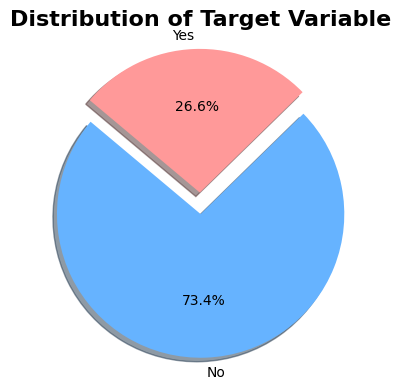

In [19]:
import matplotlib.pyplot as plt

# Stylish pie chart
colors = ['#66b3ff', '#ff9999']  # Custom colors for No and Yes
explode = (0.05, 0.1)  # Slightly "explode" the slices

plt.figure(figsize=(4, 4))
plt.pie(
    y.value_counts(),
    labels=['No', 'Yes'],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 10, 'color': 'black'}
)
plt.title('Distribution of Target Variable', fontsize=16, fontweight='bold')
plt.axis('equal')  # Ensures the pie is a circle
plt.tight_layout()
plt.show()


Here the data is not balaced as the ratio here is 73:27, which exceeds 70:30 ratio
**Hence it is imbalance**

**So to fix these imbalance we are using SMOTE technique**

In [20]:
# Print the class distribution before applying SMOTE-ENN
print("Before SMOTE-ENN:", Counter(y))


# Apply SMOTE-ENN : fix imbalanced data
smote = SMOTEENN(random_state=42)
x_st, y_st = smote.fit_resample(x, y)


# Print the class distribution after applying SMOTE-ENN
print("After SMOTE-ENN:", Counter(y_st))


Before SMOTE-ENN: Counter({0: 5163, 1: 1869})
After SMOTE-ENN: Counter({1: 3051, 0: 2688})


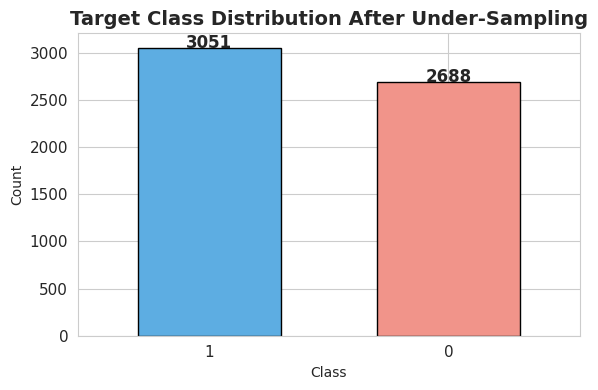

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a modern style using seaborn
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4))

# Bar plot with custom colors
bar_colors = ['#5DADE2', '#F1948A']  # Blue and Red tones
y_st.value_counts().plot(
    kind="bar",
    color=bar_colors,
    edgecolor='black',
    width=0.6
)

# Add value labels on top of bars
for i, v in enumerate(y_st.value_counts()):
    plt.text(i, v + 0.5, str(v), ha='center', fontweight='bold', fontsize=12)

# Titles and labels
plt.title("Target Class Distribution After Under-Sampling", fontsize=14, fontweight='bold')
plt.xlabel("Class", fontsize=10)
plt.ylabel("Count", fontsize=10)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


In [23]:
y_st.value_counts()

,count
Churn,
1,3051
0,2688


### Now split training and validation set using balanced dataset


In [24]:
x_train,x_test,y_train,y_test=train_test_split(x_st,y_st,test_size=0.2,random_state=42)

In [25]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((4591, 7), (4591,), (1148, 7), (1148,))

**Model Training**

**Logistic Regression**

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],           # Regularization strength
    'penalty': ['l1', 'l2'],                # Regularization types
    'solver': ['liblinear', 'saga']         # Solvers that support both l1 and l2
}

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=param_grid_lr,
    cv=5,
    scoring='accuracy',
    verbose=1
)

# Fit model
grid_search_lr.fit(x_train, y_train)

# Print best parameters
print("🔍 Best Logistic Regression Parameters:", grid_search_lr.best_params_)

# Get best estimator
logreg_best_model = grid_search_lr.best_estimator_

# Evaluate model
evaluate_model_performance(logreg_best_model, x_test)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
🔍 Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Validation Accurary : 0.93 %
Precision Score : 0.93 %
Recall Score : 0.93 %
F1 Score : 0.93 %
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       554
           1       0.93      0.93      0.93       594

    accuracy                           0.93      1148
   macro avg       0.93      0.93      0.93      1148
weighted avg       0.93      0.93      0.93      1148



**Random Forest Classifier**

In [26]:
#Finding best hyper parameters using Randomized Search CV

param_grid={'n_estimators':[40,80,120,160,200],
            'max_depth':[2,4,6,8,10],
            "criterion":['gini'],
            "random_state":[27,42,43]
            }
random_search_cv=RandomizedSearchCV( estimator=RandomForestClassifier(), param_distributions=param_grid,n_iter=12,cv=5,scoring='f1',verbose=1)
random_search_cv.fit(x_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=12,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [2, 4, 6, 8, 10],
                                        'n_estimators': [40, 80, 120, 160, 200],
                                        'random_state': [27, 42, 43]},
                   scoring='f1', verbose=1)

In [27]:
random_search_cv.best_params_

{'random_state': 27, 'n_estimators': 40, 'max_depth': 10, 'criterion': 'gini'}

In [28]:
print('Best Parameters:', random_search_cv.best_params_)

Best Parameters: {'random_state': 27, 'n_estimators': 40, 'max_depth': 10, 'criterion': 'gini'}


In [29]:
#Get final model with best param from RandomizedSearchCV
rf_final_model=random_search_cv.best_estimator_

In [30]:
#evaluate Random Forest Classifier
evaluate_model_performance(rf_final_model,x_test)

Validation Accurary : 0.96 %
Precision Score : 0.95 %
Recall Score : 0.97 %
F1 Score : 0.96 %
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       554
           1       0.95      0.97      0.96       594

    accuracy                           0.96      1148
   macro avg       0.96      0.96      0.96      1148
weighted avg       0.96      0.96      0.96      1148



**XGBoost Classifier**

In [31]:
#Finding best hyper parameters using Randomized Search CV

param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [2, 4, 6, 8],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [0, 0.1, 0.5, 1.0],
    'objective': ['binary:logistic']
}

# Create RandomizedSearchCV for XGBoost
RandomizedSearch_xg_cv = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=param_grid,
    cv=5,
    scoring='accuracy',
    random_state=42
)

# Fit RandomizedSearchCV
RandomizedSearch_xg_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           random_state=42, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'max_depth': [2, 4, 6, 8],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300],
                                        'objective': ['binary:logistic'],
                                        'reg_alpha': [0, 0.1, 0.5, 1.0],
                                        'reg_lambda': [0, 0.1, 0.5, 1.0],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, scoring='accuracy')

In [32]:
RandomizedSearch_xg_cv.best_params_

{'subsample': 0.9,
 'reg_lambda': 1.0,
 'reg_alpha': 0.5,
 'objective': 'binary:logistic',
 'n_estimators': 250,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'colsample_bytree': 0.8}

In [33]:
print('Best Parameters:', RandomizedSearch_xg_cv.best_params_)

Best Parameters: {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'objective': 'binary:logistic', 'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.8}


In [34]:
xg_smote_model=RandomizedSearch_xg_cv.best_estimator_

In [35]:
#evaluate xg boost Classifier
evaluate_model_performance(xg_smote_model,x_test)

Validation Accurary : 0.96 %
Precision Score : 0.95 %
Recall Score : 0.97 %
F1 Score : 0.96 %
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       554
           1       0.95      0.97      0.96       594

    accuracy                           0.96      1148
   macro avg       0.96      0.96      0.96      1148
weighted avg       0.96      0.96      0.96      1148



**Saving the Best Model which is xgboost_model**

In [42]:
import joblib

# Assuming xg_smote_model is your trained XGBoost model
joblib.dump(xg_smote_model, 'xgboost_model.joblib')
loaded_xgb_model = joblib.load('xgboost_model.joblib')
